### Starbucks Capstone Challenge
# Model Training

This notebook aims to train the models proposed to classify offers as appropriate or not.

## Define functions to train the classifiers

### Import the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from models import LinearNN, RecurrentNN

### Load the datasets

In [2]:
!unzip -o dataloaders.zip
train_dataloader, valid_dataloader, test_dataloader = \
    torch.load('dataloaders.pt')

Archive:  dataloaders.zip
  inflating: dataloaders.pt          


### Define validation and training loops

In [3]:
def validate(model, dataloader=valid_dataloader, verbose=False):
    with torch.no_grad():
        model.eval()
        POS, NEG = 0, 0
        TP, TN, FP, FN = 0, 0, 0, 0
        valid_loss = 0
        for features, targets in dataloader:
            targets = targets.view(-1)
            positive = targets == 1
            negative = ~positive

            prediction = model(features)
            prediction = prediction.view(-1,2)
            targets = targets.view(-1)
            valid_loss += criterion(prediction, targets)

            prediction = torch.softmax(prediction, dim=1)
            _, prediction = prediction.topk(1, dim=1)
            prediction = prediction.squeeze()

            ## Compare prediction with target POSITIVE
            POS += positive.sum()
            # Target TRUE, Prediction TRUE --> True Positive
            TP += targets[positive].eq(prediction[positive]).sum()

            ## Compare prediction with target NEGATIVE
            NEG += negative.sum()
            # Target FALSE, Prediction FALSE --> True Negative
            TN += targets[negative].eq(prediction[negative]).sum()

        FN += POS - TP # Target TRUE, Prediction FALSE --> False Negative
        FP += NEG - TN # Target FALSE, Prediction TRUE --> False Positive

        # normalize the loss
        valid_loss /= len(dataloader)

        if verbose:
            print(f'\tValidation ... loss: {valid_loss:7.4f}')
            print(f'\t\tTP: {TP:4d}\tFP: {FP:4d}\tOP: {TP+FP:4d}')
            print(f'\t\tFN: {FN:4d}\tTN: {TN:4d}\tON: {TN+FN:4d}')
            print(f'\t\tCP: {POS:4d}\tCN: {NEG:4d}')
            print('\tAccuracy: {:5.2f}%\tPrecision: {:5.2f}\tRecall: {:5.2f}'
                  .format((TP+TN)/float(POS+NEG)*100,
                          TP/float(TP+FP), TP/float(TP+FN)))

        model.train()
        return valid_loss

In [4]:
def train(model, model_name='classifier',
          dataloader=train_dataloader, epochs=5000):
    train_loss = []
    valid_loss = []
    min_valid_loss = np.inf
    ## Perform N epochs of training
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        for batch, (features, targets) in enumerate(dataloader):
            ## Train the network
            optimizer.zero_grad()
            prediction = model(features)
            prediction = prediction.view(-1,2)
            targets = targets.view(-1)
            loss = criterion(prediction, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Normalize the loss
        epoch_loss /= len(dataloader)
        train_loss.append(epoch_loss)
        lr_scheduler.step(train_loss[-1])

        if epoch % 10 == 0:
            print('Epoch {:4d}\ttrain loss: {:7.4f}\t' \
                  .format(epoch, train_loss[-1]))
            loss = validate(model, verbose=True)
            valid_loss.append(loss)
        else:
            loss = validate(model, verbose=False)
            valid_loss.append(loss)
            print('Epoch {:4d}\ttrain loss: {:7.4f}\tvalid loss: {:7.4f}' \
                  .format(epoch, train_loss[-1], valid_loss[-1]))

        if valid_loss[-1] < min_valid_loss:
            min_valid_loss = valid_loss[-1]
            torch.save(model.state_dict(), model_name+'.pt')

    return train_loss, valid_loss

## Linear Classifier
This phase trains a feed-forward neural network to classify offer sending as appropriate or not.  
Being a traditional classification approach, this model will be the benchmark model to compare other classification methods.

In [5]:
linear_classifier = LinearNN(input_size=16, output_size=2,
                             hidden_layers=[128,128,128])
criterion = nn.CrossEntropyLoss(torch.tensor([(42200. / 34072.), 1.]))
optimizer = optim.Adam(linear_classifier.parameters(), lr=0.0001, weight_decay=0.0001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.2, patience=20, verbose=True)

In [6]:
linear_loss = train(linear_classifier,
                    model_name='linear_classifier',
                    epochs=100)

Epoch    1	train loss:  0.6357	valid loss:  0.6014
Epoch    2	train loss:  0.6014	valid loss:  0.5913
Epoch    3	train loss:  0.5946	valid loss:  0.5876
Epoch    4	train loss:  0.5911	valid loss:  0.5852
Epoch    5	train loss:  0.5889	valid loss:  0.5835
Epoch    6	train loss:  0.5877	valid loss:  0.5825
Epoch    7	train loss:  0.5859	valid loss:  0.5816
Epoch    8	train loss:  0.5846	valid loss:  0.5805
Epoch    9	train loss:  0.5834	valid loss:  0.5800
Epoch   10	train loss:  0.5831	
	Validation ... loss:  0.5790
		TP: 2375	FP: 1214	OP: 3589
		FN: 1910	TN: 4041	ON: 5951
		CP: 4285	CN: 5255
	Accuracy: 67.25%	Precision:  0.66	Recall:  0.55
Epoch   11	train loss:  0.5819	valid loss:  0.5782
Epoch   12	train loss:  0.5807	valid loss:  0.5796
Epoch   13	train loss:  0.5808	valid loss:  0.5789
Epoch   14	train loss:  0.5794	valid loss:  0.5777
Epoch   15	train loss:  0.5796	valid loss:  0.5778
Epoch   16	train loss:  0.5786	valid loss:  0.5775
Epoch   17	train loss:  0.5782	valid loss:  0.

## Recurrent Classifier
This phase trains a recurrent neural network to classify offer sending as appropriate or not.  
This project proposes this model as the most suitable classification approach, considering the fact that the data is sequential.

In [7]:
recurrent_classifier = RecurrentNN(input_size=16, output_size=2,
                                   hidden_size=128, hidden_layers=2)
criterion = nn.CrossEntropyLoss(torch.tensor([(42200. / 34072.), 1.]))
optimizer = optim.Adam(recurrent_classifier.parameters(), lr=0.0001, weight_decay=0.0001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.2, patience=20, verbose=True)

In [8]:
recurrent_loss = train(recurrent_classifier,
                       model_name='recurrent_classifier',
                       epochs=100)

Epoch    1	train loss:  0.6581	valid loss:  0.6429
Epoch    2	train loss:  0.6281	valid loss:  0.6156
Epoch    3	train loss:  0.6096	valid loss:  0.6069
Epoch    4	train loss:  0.6042	valid loss:  0.6035
Epoch    5	train loss:  0.6004	valid loss:  0.6002
Epoch    6	train loss:  0.5978	valid loss:  0.5975
Epoch    7	train loss:  0.5953	valid loss:  0.5949
Epoch    8	train loss:  0.5937	valid loss:  0.5941
Epoch    9	train loss:  0.5926	valid loss:  0.5916
Epoch   10	train loss:  0.5914	
	Validation ... loss:  0.5913
		TP: 2160	FP: 1145	OP: 3305
		FN: 2125	TN: 4110	ON: 6235
		CP: 4285	CN: 5255
	Accuracy: 65.72%	Precision:  0.65	Recall:  0.50
Epoch   11	train loss:  0.5907	valid loss:  0.5904
Epoch   12	train loss:  0.5900	valid loss:  0.5904
Epoch   13	train loss:  0.5898	valid loss:  0.5901
Epoch   14	train loss:  0.5890	valid loss:  0.5897
Epoch   15	train loss:  0.5884	valid loss:  0.5887
Epoch   16	train loss:  0.5879	valid loss:  0.5888
Epoch   17	train loss:  0.5875	valid loss:  0.

## Results

### Training phase

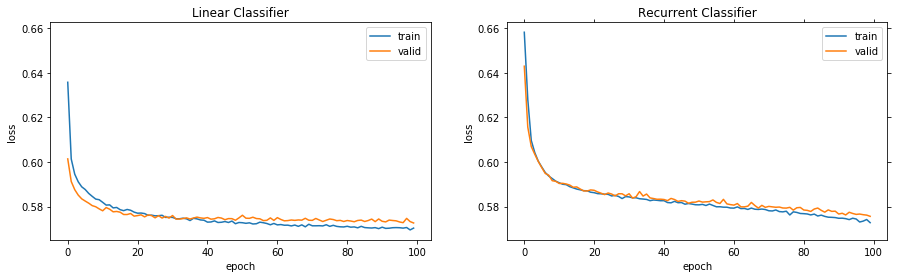

In [9]:
fig, (ax0, ax1) = plt.subplots(
    figsize=(15,4), nrows=1, ncols=2, sharey=True)

ax0.plot(linear_loss[0], label='train')
ax0.plot(linear_loss[1], label='valid')
ax0.set_title('Linear Classifier')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend()

ax1.plot(recurrent_loss[0], label='train')
ax1.plot(recurrent_loss[1], label='valid')
ax1.set_title('Recurrent Classifier')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend()
ax1.tick_params(reset=True)

plt.show()

### Testing the trained models

In [10]:
## Load the saved models

# Linear
linear_classifier.load_state_dict(
    torch.load('linear_classifier.pt'))

# Recurrent
recurrent_classifier.load_state_dict(
    torch.load('recurrent_classifier.pt'))

print('Models loaded successfully')

Models loaded successfully


In [11]:
## Test models

print('Linear Classifier')
loss = validate(linear_classifier, test_dataloader, verbose=True)

print('\nRecurrent Classifier')
loss = validate(recurrent_classifier, test_dataloader, verbose=True)

Linear Classifier
	Validation ... loss:  0.5650
		TP: 2402	FP: 1188	OP: 3590
		FN: 1885	TN: 4059	ON: 5944
		CP: 4287	CN: 5247
	Accuracy: 67.77%	Precision:  0.67	Recall:  0.56

Recurrent Classifier
	Validation ... loss:  0.5659
		TP: 2260	FP:  968	OP: 3228
		FN: 2027	TN: 4279	ON: 6306
		CP: 4287	CN: 5247
	Accuracy: 68.59%	Precision:  0.70	Recall:  0.53
